Features: Only 24 Hours lag and forecast

Data timespan: 2017-10-07 23:00:00 to 2021-03-18 00:00:00
Total records: 30143
Data frequency: 0 days 01:00:00

NaN counts in key columns:

Available columns:
['id', 'period_id', 'forecast_demand', 'date_time_current', 'date_time_future', 'date_time_current_rounded', 'total_demand', 'temperature_current', 'forecast_interval', 'Temperature', 'Humidity', 'Wind_speed', 'Rain', 'forecast_error', 'forecast_error_lag24h']

NaN counts in features:
forecast_demand: 0 NaNs
forecast_error_lag24h: 24 NaNs

Shape before dropping missing values: (30143, 4)
Shape after dropping NaN values: (30119, 4)

Training set: 21083 records (70%)
Test set: 9036 records (30%)
Training date period: 2017-10-08 11:00:00 to 2020-03-05 22:00:00
Test date period: 2020-03-05 23:00:00 to 2021-03-17 12:00:00

Model Performance:
- MSE: 51971.086
- MAPE: 2.111%

Original Forecast Performance:
- MSE: 55152.352
- MAPE: 2.179%

Improvement Over Original Forecast:
- MSE: 5.768%
- MAPE: 3.105%

Feature Importance:
             

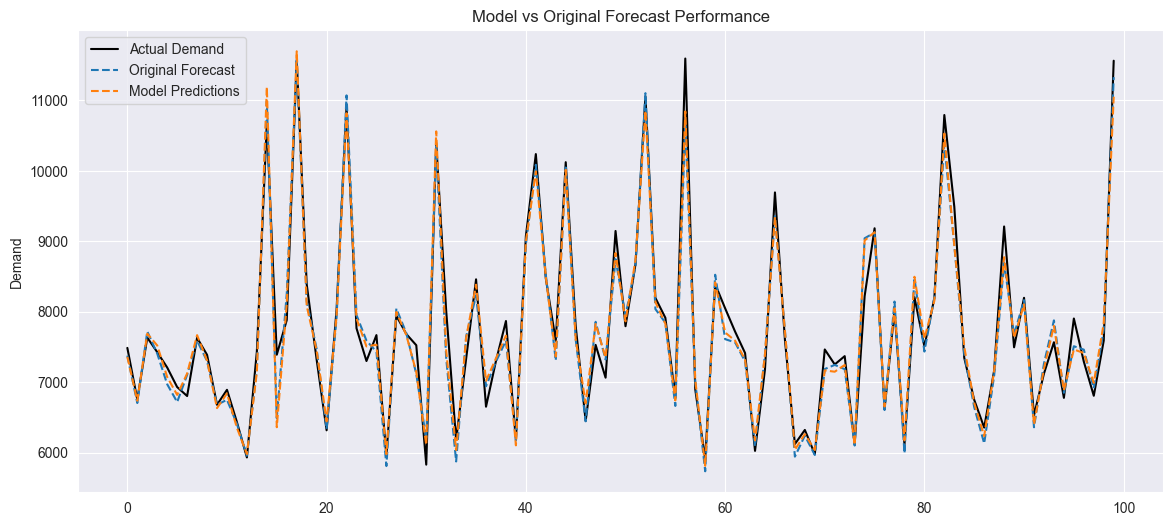

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = r"C:\Users\waseem\Downloads\combined_data_new.csv"  # change path
df = pd.read_csv(file_path)


# Convert to datetime
df["date_time_current_rounded"] = pd.to_datetime(df["date_time_current_rounded"])
df["date_time_future"] = pd.to_datetime(df["date_time_future"])

# Filter for PERIODID 24 and sort
df_sliced = df[df["period_id"] == 24].copy()
df_sliced = df_sliced.sort_values("date_time_future")
df_sliced = df_sliced.dropna()


# Basic dataset info
print(f"Data timespan: {df_sliced['date_time_future'].min()} to {df_sliced['date_time_future'].max()}")
print(f"Total records: {len(df_sliced)}")
print(f"Data frequency: {df_sliced['date_time_future'].diff().value_counts().index[0]}")


# Get forecast error
df_sliced['forecast_error'] = df_sliced['total_demand'] - df_sliced['forecast_demand']
df_sliced['forecast_error_lag24h'] = df_sliced.sort_values('date_time_current_rounded')['forecast_error'].shift(24)



# Check for NaN counts in key columns
print("\nNaN counts in key columns:")
for col in ['demand_lag_24h', 'demand_lag_48h', 'demand_lag_7d', 'forecast_error_lag12h']:
    if col in df_sliced.columns:
        print(f"{col}: {df_sliced[col].isna().sum()} NaNs")

# Define features that would be available at prediction time (12 hours ahead)
features = [
    # Basic time features


    # Original forecast
    'forecast_demand',
    'forecast_error_lag24h'


]


# Define target
target = 'total_demand'

# Print the columns in the dataframe
print("\nAvailable columns:")
print(df_sliced.columns.tolist())

# Print the number of NaN values for each feature
print("\nNaN counts in features:")
for feature in features:
    print(f"{feature}: {df_sliced[feature].isna().sum()} NaNs")

# Create the modeling dataframe
model_df = df_sliced[features + [target] + ['date_time_current_rounded']].copy()

# Print the shape before dropping missing values
print(f"\nShape before dropping missing values: {model_df.shape}")

# Drop rows with NaN values
model_df = model_df.dropna()
print(f"Shape after dropping NaN values: {model_df.shape}")

# If we still have no data, show a clear error and exit
if len(model_df) == 0:
    print("ERROR: No data left after dropping NaN values!")
    import sys
    sys.exit(1)

# Sort data to ensure temporal order
model_df = model_df.sort_values('date_time_current_rounded').reset_index(drop=True)

# Split data temporally - use 70-30 split
X = model_df[features]
y = model_df[target]
train_size = 0.7
split_idx = int(len(model_df) * train_size)

# Split into train/test
X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

# Print split info with actual dates
print(f"\nTraining set: {len(X_train)} records ({train_size*100:.0f}%)")
print(f"Test set: {len(X_test)} records ({(1-train_size)*100:.0f}%)")
print(f"Training date period: {model_df['date_time_current_rounded'].iloc[0]} to {model_df['date_time_current_rounded'].iloc[split_idx-1]}")
print(f"Test date period: {model_df['date_time_current_rounded'].iloc[split_idx]} to {model_df['date_time_current_rounded'].iloc[-1]}")

# Train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_original = X_test["forecast_demand"]

# Evaluate performance
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(0.001, y_true))) * 100
    return mse, mape

# Model metrics
model_mse, model_mape = calculate_metrics(y_test, y_pred)

# Original forecast metrics
original_mse, original_mape = calculate_metrics(y_test, y_pred_original)

# Print formatted results
print("\nModel Performance:")
print(f"- MSE: {model_mse:.3f}")
print(f"- MAPE: {model_mape:.3f}%")

print("\nOriginal Forecast Performance:")
print(f"- MSE: {original_mse:.3f}")
print(f"- MAPE: {original_mape:.3f}%")

# Calculate improvement percentages
improvement_mse = (1 - model_mse/original_mse) * 100
improvement_mape = (1 - model_mape/original_mape) * 100

print("\nImprovement Over Original Forecast:")
print(f"- MSE: {improvement_mse:.3f}%")
print(f"- MAPE: {improvement_mape:.3f}%")

# Feature importance
feature_importance = pd.DataFrame(
    {'Feature': features,
     'Importance': model.feature_importances_}
).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot actual vs. predicted
# Plot a sample of 100 data points
sample = np.random.choice(len(y_test), 100, replace=False)
x_axis = range(len(sample))

plt.figure(figsize=(14, 6))
sns.lineplot(x=x_axis, y=y_test.iloc[sample], label='Actual Demand', color='black')
sns.lineplot(x=x_axis, y=y_pred_original.iloc[sample], label='Original Forecast', linestyle='--')
sns.lineplot(x=x_axis, y=y_pred[sample], label='Model Predictions', linestyle='--')
plt.title("Model vs Original Forecast Performance")
plt.ylabel("Demand")
plt.show()